In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# Solving PDEs

All the PDEs will be considered on the domain $(x,y)\in[0,1]^2$

In [2]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

## Example 5

$\Delta\Psi(x, y)=\exp(-x)\left(x-2+y^3+6y\right)$

With boundary conditions $\Psi(0,y)=y^3$, $\Psi(1, y)=(1+y^3)e^{-1}$, $\Psi(x, 0)=xe^{-x}$, and $\Psi(x, 1)=(1+x)e^{-x}$.

The trial solution for this case is $\Psi(x, y)=A(x, y) + B(x, y)N(x, y)$ with $B(x)=x(1-x)y(1-y)$ and $$A(x, y)= (1-x)y^3+x(1+y^3)e^{-1}+(1-y)x(e^{-x}-e^{-1})+y[(1+x)e^{-x} - (1-x+2xe^{-1})].$$

In [3]:
def example5_boundary_value(point):
  x = point[0]
  y = point[1]
  expmx = np.exp(-x)
  y3 = y ** 3
  return ((1-x) * y3 + x * (1 + y3) * np.exp(-1)
          + (1-y) * x * (expmx - np.exp(-1))
          + y * ((1 + x) * expmx - (1 - x + 2 * x * np.exp(-1)))
         )

In [4]:
def example5_boundary_vanishing(point):
  x = point[0]
  y = point[1]
  return x * (1 - x) * y * (1 - y)

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(\Delta\Psi(x_i, N(x_i))-\exp(-x)\left(x-2+y^3+6y\right) \right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$\Delta\Psi(x_i, N(x_i))=\Delta A(x,y) + \Delta (x(1-x)y(1-y)N(x,y))$$
$$=e^{-x}(x+y-2)+6y(1-x+xe^{-1}) - 2N(x,y)(y(1-y)+x(1-x))+2\frac{\partial N}{\partial x}(x,y)(1-2x)y(1-y)+2\frac{\partial N}{\partial y}(x,y)(1-2y)x(1-x)+x(1-x)y(1-y)(\frac{\partial^2 N}{\partial x^2}(x,y)+\frac{\partial^2 N}{\partial y^2}(x,y))$$

In [5]:
def example5_loss_function_single_point(self, point, non_squared=False, *kwargs):
  x = point[0]
  y = point[1]
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  loss = ( np.exp(-x) * (x+y-2)+6*y*(1-x+x*np.exp(-1)) - 2 * N * (y*(1-y)+x*(1-x)) + 2 * dN[0, 0] * (1-2*x)*y*(1-y)
          + 2 * dN[0, 1] * (1-2*y)*x*(1-x) + x*(1-x)*y*(1-y)*(d2N[0, 0]+d2N[0, 1]) - np.exp(-x) * (x - 2 + y ** 3 + 6 *y)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [6]:
def example5_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [7]:
def example5_bias_change(self, point, label, *kwargs):
  x = point[0]
  y = point[1]
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( - 2 * db_N[0, 0, m] * (y*(1-y)+x*(1-x)) + 2 * db_DN[0, 0, m] * (1-2*x)*y*(1-y)
          + 2 * db_DN[0, 1, m] * (1-2*y)*x*(1-x) + x*(1-x)*y*(1-y)*(db_D2N[0, 0, m]+db_D2N[0, 1, m])
      )
  return db

In [8]:
def example5_hidden_weights_change(self, point, *kwargs):
  x = point[0]
  y = point[1]
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (- 2 * dH_N[0, 0, m, p] * (y*(1-y)+x*(1-x)) + 2 * dH_DN[0, 0, m, p] * (1-2*x)*y*(1-y)
          + 2 * dH_DN[0, 1, m, p] * (1-2*y)*x*(1-x) + x*(1-x)*y*(1-y)*(dH_D2N[0, 0, m, p]+dH_D2N[0, 1, m, p])
      )
  return dH

In [9]:
def example5_visible_weights_change(self, point, *kwargs):
  x = point[0]
  y = point[1]
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (- 2 * dV_N[0, 0, m, p] * (y*(1-y)+x*(1-x)) + 2 * dV_DN[0, 0, m, p] * (1-2*x)*y*(1-y)
          + 2 * dV_DN[0, 1, m, p] * (1-2*y)*x*(1-x) + x*(1-x)*y*(1-y)*(dV_D2N[0, 0, m, p]+dV_D2N[0, 1, m, p])   
      )
  return dV

### Defining the trial solution with an apropiate network

In [10]:
example5_trial_solution = nnde.TrialSolution(loss_function=example5_loss_function,
                                        loss_function_single_point=example5_loss_function_single_point,
                                        bias_change=example5_bias_change,
                                        hidden_weights_change=example5_hidden_weights_change,
                                        visible_weights_change=example5_visible_weights_change,
                                        boundary_condition_value_function=example5_boundary_value,
                                        boundary_vanishing_function=example5_boundary_vanishing,
                                        input_dim=2, hidden_dim=10, output_dim=1, learning_rate=0.1, momentum=0)

### Training for 5000 epochs

In [11]:
example5_trial_solution.train(samples, 100)

Epoch: 1 Loss function: 0.01093153752640883
Epoch: 2 Loss function: 0.002355925244360101
Epoch: 3 Loss function: 0.0007149526870161725
Epoch: 4 Loss function: 0.0004997473262840531
Epoch: 5 Loss function: 0.000440335086726995
Epoch: 6 Loss function: 0.0004340666191388969
Epoch: 7 Loss function: 0.00042937343423704734
Epoch: 8 Loss function: 0.0004273075508078971
Epoch: 9 Loss function: 0.0003704811468185425
Epoch: 10 Loss function: 0.000371848318733582
Epoch: 11 Loss function: 0.0003588042239716536
Epoch: 12 Loss function: 0.0003563030578479543
Epoch: 13 Loss function: 0.0003591456922538984
Epoch: 14 Loss function: 0.0003501903252272154
Epoch: 15 Loss function: 0.0003526658697687789
Epoch: 16 Loss function: 0.00035054462689300425
Epoch: 17 Loss function: 0.0003649583949078527
Epoch: 18 Loss function: 0.000335882045844819
Epoch: 19 Loss function: 0.0003254566902388181
Epoch: 20 Loss function: 0.00036085330848927336
Epoch: 21 Loss function: 0.0003192950760756827
Epoch: 22 Loss function: 

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

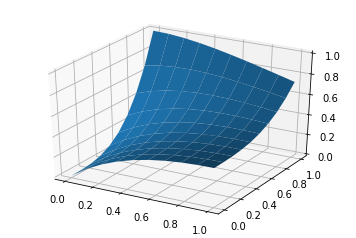

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze5sol = np.array([example5_trial_solution.predict(samples[i]) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5sol.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=Ze5sol, label='Numerical - Training')
# plt.legend()
plt.show()

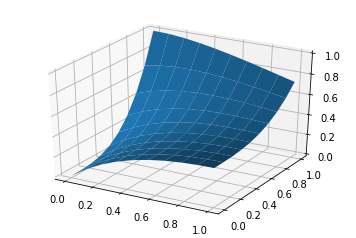

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = (samples[:,0] + samples[:,1]**3) * np.exp(-samples[:, 0])
Ze5diff = Ze5sol - Ze5anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5anal.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [14]:
Ze5diff.max()

0.00071115091217337629515

### Checking if the mixed parials work

In [15]:
example5_trial_solution.network.forward_pass_arbitrary_derivative(np.array([0.5, 0.5]), np.array([2, 1]))

array([[-0.59156903]], dtype=float128)

In [16]:
example5_trial_solution.network.hidden_layer.weights

array([[ 0.6317394 ,  0.5305962 ],
       [-0.89797549, -0.51717685],
       [ 0.27213375, -0.45112731],
       [ 0.13941497, -0.58855877],
       [-0.52298335,  0.04804507],
       [ 0.72332257,  0.82498413],
       [ 0.19938095, -1.20917665],
       [ 0.03622569, -0.27285264],
       [-0.89650269,  0.0015307 ],
       [ 0.76724336, -0.68649737]])

In [17]:
p_test = example5_trial_solution.network.hidden_layer.weights[:, 0] ** 2 * example5_trial_solution.network.hidden_layer.weights[:, 1]
p_test = p_test.reshape((p_test.shape[0],1))
p_test

array([[  2.11758111e-01],
       [ -4.17030712e-01],
       [ -3.34090360e-02],
       [ -1.14395417e-02],
       [  1.31408832e-02],
       [  4.31628011e-01],
       [ -4.80681143e-02],
       [ -3.58064602e-04],
       [  1.23024969e-03],
       [ -4.04115176e-01]])

In [18]:
p_test - example5_trial_solution.network.derivative_P_vector(degrees=np.array([2, 1]))

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [19]:
dx2dyN = example5_trial_solution.network.visible_layer.weights @ (
  p_test * example5_trial_solution.network.hidden_layer.activation_function(
    example5_trial_solution.network.hidden_layer.linear_response(np.array([0.5, 0.5])), 3 ))
dx2dyN

array([[-0.59156903]], dtype=float128)

In [20]:
dx2dyN - example5_trial_solution.network.forward_pass_arbitrary_derivative(np.array([0.5, 0.5]), degrees=np.array([2, 1]))

array([[ 0.0]], dtype=float128)

In [21]:
db_dx2dyN = example5_trial_solution.network.visible_layer.weights * (p_test * example5_trial_solution.network.hidden_layer.activation_function(
    example5_trial_solution.network.hidden_layer.linear_response(np.array([0.5, 0.5])), 4 )).T
db_dx2dyN

array([[ 1.7821989, -0.19549486,  0.012371028, -0.029999473,  0.048050138,
         2.0171501,  0.19606545,  0.0001091935,  0.0010065822,  0.36007147]], dtype=float128)

In [22]:
db_dx2dyN - example5_trial_solution.network.arbitrary_network_derivative_bias(np.array([0.5, 0.5]), degrees=np.array([2, 1]) )

array([[ 1.5373987e-16, -6.6271858e-18,  1.6517142e-19, -4.1335208e-19,
         1.0774259e-18, -1.5027042e-16, -6.3561352e-18,  2.3491929e-21,
        -2.1387582e-20,  2.4259024e-17]], dtype=float128)

In [23]:
dH_dx2dyN = np.zeros((1, 10, 2))
V = example5_trial_solution.network.visible_layer.weights
hanp1 = example5_trial_solution.network.hidden_layer.activation_function(
    example5_trial_solution.network.hidden_layer.linear_response(np.array([0.5, 0.5])), 4 )
han = example5_trial_solution.network.hidden_layer.activation_function(
    example5_trial_solution.network.hidden_layer.linear_response(np.array([0.5, 0.5])), 3 )
point_test = np.array([0.5, 0.5])
degrees = np.array([2, 1])
H = example5_trial_solution.network.hidden_layer.weights
for j in range(1):
  for m in range(10):
    for p in range(2):
      dH_dx2dyN[j, m, p] = V[j, m] * p_test[m] * han[m] * degrees[p] / H[m, p]+V[j, m] * p_test[m] * hanp1[m] * point_test[p] 
dH_dx2dyN

array([[[  1.36161395e-01,   4.41676605e-01],
        [ -2.19404487e-01,  -2.03364159e-01],
        [ -1.42650976e-02,   1.23537303e-02],
        [  9.01055292e-02,  -2.74481509e-02],
        [  6.37314910e-02,  -1.92082401e-01],
        [  2.25699437e-01,   6.65373532e-01],
        [ -3.81679680e-01,   1.37582580e-01],
        [ -1.33118890e-03,   1.46589694e-04],
        [  9.98458275e-04,  -1.44501843e-01],
        [ -4.22121496e-03,   2.83000381e-01]]])

In [24]:
dH_dx2dyN - example5_trial_solution.network.arbitrary_network_derivative_hidden_weights(np.array([0.5, 0.5]), degrees=np.array([2, 1]) )

array([[[ -2.78013949e-01,   0.00000000e+00],
        [ -2.30902114e-01,   0.00000000e+00],
        [ -1.48853099e-02,   0.00000000e+00],
        [  9.04520189e-02,   3.46944695e-18],
        [  6.04722192e-02,   0.00000000e+00],
        [ -2.16604012e-01,  -1.11022302e-16],
        [ -3.84066891e-01,   0.00000000e+00],
        [ -1.33558461e-03,   0.00000000e+00],
        [  9.39085889e-04,   0.00000000e+00],
        [ -4.28870274e-02,   0.00000000e+00]]])

In [25]:
dV_dx2dyN = (p_test * example5_trial_solution.network.hidden_layer.activation_function(
    example5_trial_solution.network.hidden_layer.linear_response(np.array([0.5, 0.5])), 3 )).reshape((1,1,p_test.shape[0]))
dV_dx2dyN

array([[[-0.84098143,  0.25684803,  0.03478703,  0.009733274, -0.015116111,
         -1.5091372,  0.041026358,  0.00035337213, -0.0013456301,
          0.59159956]]], dtype=float128)

In [26]:
dV_dx2dyN - example5_trial_solution.network.arbitrary_network_derivative_visible_weights(np.array([0.5, 0.5]), degrees=np.array([2, 1]) )

array([[[ 2.6779794e-17,  2.7430315e-17,  1.5788694e-18, -8.5126811e-19,
          1.2874901e-19, -9.3458227e-17, -1.9346233e-18,  2.52257e-20,
          6.7974394e-20,  4.5970172e-17]]], dtype=float128)